# Twitter Analysis using Web Crawler

### Submission by: Manjiri Acharekar (msa530@nyu.edu)

Please run below command if you need any packages to be installed while running this notebook:
```
import sys
!{sys.executable} -m pip install <package-name>
```

## PART 1: Building a Web Crawler to fetch data from Twitter URL

**Target URL:** "https://www.twitter.com/Nike"

**Fetched Details:**
- Tweet Text
- Tweet Posted Date
- Tweet Posted Time
- Mentions in Tweet
- Hashtags
- Number of Replies, Likes and Retweets

**Process**
1. Crawls data using `Beautiful Soup`.
2. Fetches above given parameters from `Soup Object` and store it in a `CSV File`.

In [2]:
# Import Packages
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import numpy as np
import pandas as pd
import csv
from datetime import datetime

In [2]:
# Target URL
url = "https://www.twitter.com/Nike"

In [3]:
# Using Chrome WebDriver
driver = webdriver.Chrome()
driver.get(url)
driver.maximize_window()

In [4]:
# Beautiful Soup scrolls down to the bottom of the page
lastHeight = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
    newHeight = driver.execute_script("return document.body.scrollHeight")
    if newHeight == lastHeight:
        break
    lastHeight = newHeight

soupfetch = BeautifulSoup(driver.page_source, "html.parser")

In [22]:
# Open/Create a file to append data
csvFile = open('niketweets.csv', 'w+')
# Use csv Writer
csvWriter = csv.writer(csvFile)

In [23]:
# Initializing Parameters
tweet = []
hashtag = []
mentions = []
reply = []
like = [] 
retweet = []
date = []
time = []

In [24]:
# Fetching Twitter Data
row_count = 0
twitterwebdata = soupfetch.find_all('div', {'class': 'content'})
for twitter_tweet in twitterwebdata:
    # Fetch Tweet Text
    try:
        tweet = twitter_tweet.find('p', {'class': 'TweetTextSize'}).text
        print(tweet)
    except:
        pass
    
    # Fetch Hashtag
    hashtag = []
    for tag in twitter_tweet.find_all('a', {'class': 'twitter-hashtag'}):
        hashtag.append(tag.text[1:])
    if hashtag == []:
        hashtag = np.NaN
    #print(hashtag)
    
    # Fetch Mentions
    mentions = []
    for a in twitter_tweet.find_all('a', {'class': 'twitter-atreply'}):
        try:
            mentions.append(a['href'][1:])
        except:
            pass
    if mentions == []:
        mentions = np.NaN
    #print(mentions)
    
    # Fetch Number of Replies
    thumbs = twitter_tweet.find_all('span', \
                        {'class': 'ProfileTweet-actionCountForPresentation'})
    try:
        reply = thumbs[0].text
        if reply[-1] == 'K':
            reply = int(float(reply[:-1]) * 1000)
        else:
            reply = int(float(reply.encode))
    except:
        pass
    #print(re)
    
    # Fetch Number of Likes
    try:
        like = thumbs[3].text
        if like[-1] == 'K':
            like = int(float(like[:-1])*1000)
        else:
            like = int(float(like))
    except:
        pass
    #print(like)
    
    # Fetch Number of Retweets
    try:
        retweet = thumbs[2].text
        if retweet[-1] == 'K':
            retweet = int(float(retweet[:-1])*1000)
        else:
            retweet = int(float(retweet))
    except:
        pass
    #print(retweet)
    
    # Fetch Posted Tweet Date
    try:
        date = twitter_tweet.find("a",attrs={"class":"tweet-timestamp js-permalink js-nav js-tooltip"})["title"].split('-')[1]
    except:
        date = None
        pass
    #print(date)
    
    # Fetch Posted Tweet Time
    try:
        time = twitter_tweet.find("a",attrs={"class":"tweet-timestamp js-permalink js-nav js-tooltip"})["title"].split('-')[0]
    except:
        time = None
        pass
    #print(time)
    
    #print(tweet, hashtag, mentions, reply, like, retweet, date, time)
    
    # Data Cleaning - Eliminate tweets with No text
    if all(attributes is not None for attributes in [tweet, date, time]):
        csvWriter.writerow([tweet, hashtag, mentions, reply, like, retweet, date, time])        

Don’t ask if your dreams are crazy. Ask if they’re crazy enough. #justdoitpic.twitter.com/Wd5L42egV8
He’s done it again. 

Never stop chasing your crazy dreams. #justdoitpic.twitter.com/sVXo12E1r9
Yesterday, 2:01:39 seemed crazy. Today, it’s the marathon world record. #justdoitpic.twitter.com/dm7JeOCPqN
Don't just be the fastest marathon runner in the world. Be the fastest in history. #justdoit @EliudKipchogepic.twitter.com/jGcoNy3Wsy
Yeah, that’s more like it. #justdoit
If you’re a girl from Compton, don’t just become a tennis player.
Dream of being the greatest athlete ever.
If you have only one hand, don’t just watch football, play it. At the highest level.
When they talk about the greatest team in the history of the sport, make sure it’s your team.
Believe in something, even if it means sacrificing everything.
Don’t become the best basketball player on the planet. Be bigger than basketball.
If you’re born a refugee, don’t let it stop you from playing soccer for the national team — 

A day has enough hours. You just have too many excuses.
Back to the blueprint. #airmaxhttps://amp.twimg.com/v/0449c772-b337-475b-9a4d-a020dc7382a4 …
There is no way to return the serve if you are not facing it. #serenareturns @serenawilliamspic.twitter.com/QVVYS7UjVT
Shopping your Instagram favorites just got easier. The Nike Women’s Instagram shop is here. http://gonike.me/6016FAxn pic.twitter.com/7HcrYPZgoL
You have to get good before you are good. #betterforitpic.twitter.com/pv7z19tzKt
Today is a starting block. Not a stumbling block. #justdoit
We all sweat in the same language. #womensday
Your body will thank you later. #justdoit
Today is up to you. #justdoit
The stars of tomorrow focus on today. #justdoit
Born in 1982. 3D printed in 2015. Introducing the first AF1 figurine, made with love at the #zoomcity bank. #nikeairhttps://amp.twimg.com/v/dcca00d3-daa3-4b64-a874-983f42aaf987 …
Above the rim. Beyond comparison. @ZachLaVine #NBAAllStarNYCpic.twitter.com/pkcAy5xxLd
A court fit fo

#justdoit RT @NikeFuel Summer means time for more.pic.twitter.com/zQfY4ym6Fo
Arrive early. Start fast. #futuregetsfasterpic.twitter.com/u8QlYRTLF9
Determination determines everything. #justdoit
Champion is the only label we'll remember.pic.twitter.com/t6VhYCc4Xc
No risk. No revenge. #riskeverythingpic.twitter.com/hjkwNLj0hW
If you are not ready to risk everything, there will be no revenge. Zlatan has spoken.https://amp.twimg.com/v/012951bf-8693-4c7d-86b2-2b3d843a9b4c …
Teach the world what your country taught you. #justdoitpic.twitter.com/3ZmKSVFMVK
Today a summer of risk starts. Zlatan is here to answer your questions. Go on, #AskZlatan.https://amp.twimg.com/v/461b5db6-6422-40e1-9f57-f2581e81fd07 …
Play every game like it's 'The Last Game.' #riskeverythinghttps://amp.twimg.com/v/b108fb9d-5d87-4041-8100-29025b60a61d …
There's no greater danger than playing it safe. http://gonike.me/6016ceQ2 
If you don't take risks, you'll always have regret. #justdoit
For the king of Paris, it’s an en

Resolutions aren’t supposed to be recycled.
The greatest resolutions are the ones you keep. http://nike.com/justdoit 
Want to continue helping today's kids get moving? Build on what you accomplished on 12.21 and visit http://www.designedtomove.org  to learn more.
It may be the darkest day of the year, but you still have 24 hours. Make it matter: http://gonike.me/1221 
Tomorrow, pledge your Nike+ activity to one of 10 programs that are helping to get kids active: http://gonike.me/1221 
Every mile counts on 12.21. Hit the road for a great cause and everyone wins. #flashrun http://gonike.me/1221 
On Saturday, our @NikeFuel counts more. I'm gettin after 7k. Join me, move for good: http://gonike.me/1221  #justdoit #teamnike
There's never enough time in the day, so let's make what you do on the longest night of the year matter more: http://gonike.me/1221 
If he never came back to the game.

He'd be a living legend.

But he wouldn't be @KobeBryant. #justdoit
http://youtu.be/ikC5GIpNFWw 
When 

## PART 2: Performing Analysis on Fetched Twitter Data

In [226]:
# Loading Comma Seperated Data using read_table pandas function in 'nike_data' dataframe
nike_data = pd.read_table("niketweets.csv", sep=",", header=None)

In [227]:
# Adding Headers to Data
nike_data.columns = ["tweet", "hashtag", "mentions", "reply", "like", "retweet", "date", "time"]
nike_data

,tweet,hashtag,mentions,reply,like,retweet,date,time
0,Don’t ask if your dreams are crazy. Ask if the...,['justdoit'],NaN,16000.0,522000,228000,5 Sep 2018,10:09 AM
1,He’s done it again. \n\nNever stop chasing you...,['justdoit'],NaN,257.0,31000,6000,23 Sep 2018,5:55 PM
2,"Yesterday, 2:01:39 seemed crazy. Today, it’s t...",['justdoit'],NaN,214.0,29000,8900,16 Sep 2018,3:56 AM
3,Don't just be the fastest marathon runner in t...,['justdoit'],['EliudKipchoge'],104.0,6100,2600,15 Sep 2018,8:52 AM
4,"Yeah, that’s more like it. #justdoit",['justdoit'],NaN,1200.0,26000,5300,5 Sep 2018,10:14 AM
5,"If you’re a girl from Compton, don’t just beco...",NaN,NaN,310.0,19000,3600,5 Sep 2018,10:14 AM
6,"If you have only one hand, don’t just watch fo...",NaN,NaN,194.0,11000,2000,5 Sep 2018,10:14 AM
7,When they talk about the greatest team in the ...,NaN,NaN,168.0,11000,2400,5 Sep 2018,10:14 AM
8,"Believe in something, even if it means sacrifi...",NaN,NaN,1200.0,36000,17000,5 Sep 2018,10:14 AM
9,Don’t become the best basketball player on the...,NaN,NaN,84.0,12000,2500,5 Sep 2018,10:14 AM


### Time Analysis
**When was Nike Official most active?**
### Yearly Analysis

In [228]:
# Yearly Analysis
nike_data['date'] = pd.to_datetime(nike_data['date'])
yearly_stats = nike_data['date'].dt.year.value_counts()
yearly_stats

2014    206
2013    162
2012    159
2015     88
2016     74
2017     62
2018     54
Name: date, dtype: int64

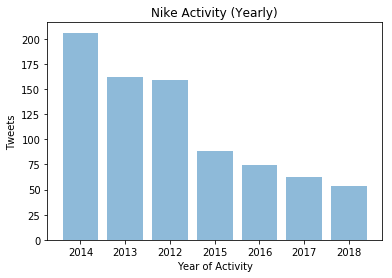

In [229]:
import pandas
from matplotlib import pyplot as plt

tweets = []
year = yearly_stats.keys().tolist()
y_pos = np.arange(len(year))
tweets = yearly_stats.tolist()

plt.bar(y_pos, tweets, align='center', alpha=0.5)
plt.xticks(y_pos, year)
plt.xlabel('Year of Activity')
plt.ylabel('Tweets')
plt.title('Nike Activity (Yearly)')
 
plt.show()

### Monthly Analysis

Link: https://news.nike.com/news/5-game-changing-nike-innovations-of-2014

In [230]:
# Monthly Analysis
monthly_stats = nike_data['date'].dt.month.value_counts()
monthly_stats

10    118
12     95
9      78
8      74
1      73
3      65
4      58
5      54
11     52
2      50
7      46
6      42
Name: date, dtype: int64

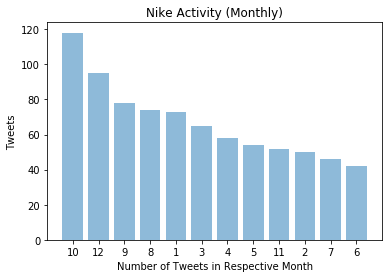

In [231]:
import pandas
from matplotlib import pyplot as plt

tweets = []
month = monthly_stats.keys().tolist()
y_pos = np.arange(len(month))
tweets = monthly_stats.tolist()

plt.bar(y_pos, tweets, align='center', alpha=0.5)
plt.xticks(y_pos, month)
plt.xlabel('Number of Tweets in Respective Month')
plt.ylabel('Tweets')
plt.title('Nike Activity (Monthly)')
 
plt.show()

Findings:
- Festivals in August, September, October and December for Marketing their products.

### Most Number of Tweets on a Single Day

In [232]:
# Most Number of Tweets on a Single Day
day_stats = nike_data['date'].value_counts().head()
day_stats

2017-05-05    19
2018-09-05    13
2012-10-17     8
2014-01-01     8
2012-11-01     8
Name: date, dtype: int64

5th May 2017 is the day of most number of tweets posted by Nike

### Hourly Analysis

In [233]:
# Hourly Analysis
nike_data['time'] = pd.to_datetime(nike_data['time'])
hourly_stats = nike_data['time'].dt.hour.value_counts().head(6)
hourly_stats

9     97
7     90
10    77
12    61
11    60
8     50
Name: time, dtype: int64

Nike Account is most active between 8 AM to 12 PM (Morning)

### Specific Timeframe Tweet

In [234]:
# Specific Timeframe Tweet
nike_data['time'] = pd.to_datetime(nike_data['time'])
specific_hourly_stats = nike_data['time'].dt.time.value_counts().head(3)
specific_hourly_stats

07:30:00    43
09:00:00    14
10:14:00    12
Name: time, dtype: int64

7:30 AM, 9:00 AM and 10:14 AM (Most Tweets)

## Hashtag and Mentions Analysis

**Which hashtags are used more frequently?**

In [235]:
# Filling Missing Values, Removing Punctation and Brackets from Hashtag Data Frame
nike_data['hashtag'] = nike_data['hashtag'].fillna("None")
nike_data['hashtag'] = nike_data['hashtag'].str.replace(r"\'","")
nike_data['hashtag'] = nike_data['hashtag'].str.replace(r"[","")
nike_data['hashtag'] = nike_data['hashtag'].str.replace(r"]","")
nike_data['hashtag'] = nike_data['hashtag'].str.replace(r",","")
nike_data['hashtag'] = nike_data['hashtag'].str.lower()

### Most Frequent Hashtags 

In [253]:
# Getting Frequency Count
freq = pd.Series(' '.join(nike_data['hashtag']).split()).value_counts()[1:9]
freq

justdoit          216
makeitcount        28
breaking2          22
airmax             18
nike               12
techpack           11
riskeverything     10
nikewomen           8
dtype: int64

Top 8 Hashtag Used by Nike Official

**Nike is associates tweets with which twitter account?**

In [237]:
# Filling Missing Values, Removing Punctation and Brackets from Mentions Data Frame
nike_data['mentions'] = nike_data['mentions'].fillna("None")
nike_data['mentions'] = nike_data['mentions'].str.replace(r"\'","")
nike_data['mentions'] = nike_data['mentions'].str.replace(r"[","")
nike_data['mentions'] = nike_data['mentions'].str.replace(r"]","")
nike_data['mentions'] = nike_data['mentions'].str.replace(r",","")

### Most Frequent Mentions by Nike

In [238]:
# Getting Frequency Count
new_df = nike_data[nike_data['mentions'].str.contains("Nike") == False]
freq = pd.Series(' '.join(new_df['mentions']).split()).value_counts()[1:6]
freq

serenawilliams    11
EliudKipchoge      8
kobebryant         7
neymarjr           7
KingJames          7
dtype: int64

Top 5 Mentions from Nike --> Nike Brand Ambassadors

### Word Cloud

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites.

In [239]:
# Keeping Word Count, Char Count and Average Count of Each Tweet
nike_data['word_count'] = nike_data['tweet'].apply(lambda x: len(str(x).split(" ")))

nike_data['char_count'] = nike_data['tweet'].str.len() ## this also includes spaces

def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

nike_data['avg_word'] = nike_data['tweet'].apply(lambda x: avg_word(x))

In [240]:
# Counting Stop Words
import nltk
# Try this if it doesn't work --> nltk.download('all')
from nltk.corpus import stopwords
stop = stopwords.words('english')
nike_data['stopwords'] = nike_data['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))

In [241]:
# Converting Data to lower case
nike_data['tweet'] = nike_data['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing Punctuation
nike_data['tweet'] = nike_data['tweet'].str.replace('[^\w\s]','')

# Removing of Stop Words
from nltk.corpus import stopwords
stop = stopwords.words('english')
nike_data['tweet'] = nike_data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### Most Frequent Words in Tweets

In [242]:
# Most frequent words in Nike's tweet
freq = pd.Series(' '.join(nike_data['tweet']).split()).value_counts()[:10]
freq

nike        145
justdoit    122
new          50
get          50
one          46
dont         36
make         36
day          30
never        27
game         27
dtype: int64

### Word Cloud Generation

In [243]:
# Word Cloud
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
    
comment_words = ' '
stopwords = set(STOPWORDS) 

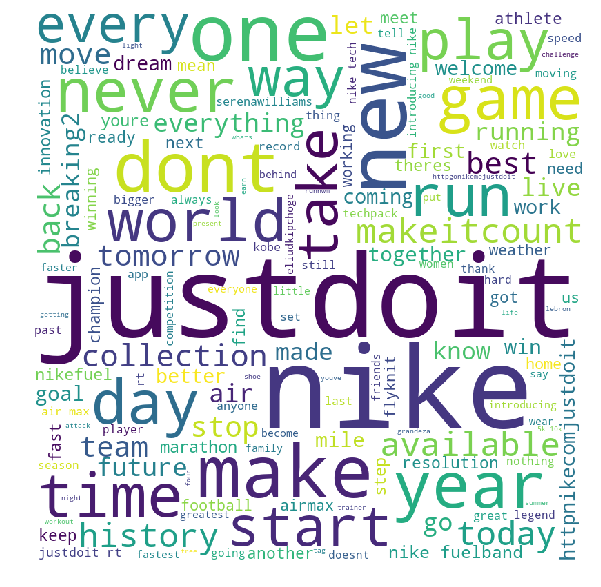

In [244]:
# iterate through the nike tweets 
for val in nike_data['tweet']: 
    # typecaste each val to string 
    val = str(val)
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Lemmatization
Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices. It makes use of the vocabulary and does a morphological analysis to obtain the root word. The below process will be helpful to find N-Grams

In [249]:
# Lemmatization
from textblob import TextBlob
TextBlob(nike_data['tweet'][1]).words

from textblob import Word
nike_data['tweet'] = nike_data['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

### N-grams
N-grams are the combination of multiple words used together. Ngrams with N=1 are called unigrams. Similarly, bigrams (N=2), trigrams (N=3) and so on can also be used.

Unigrams do not usually contain as much information as compared to bigrams and trigrams. The basic principle behind n-grams is that they capture the language structure, like what letter or word is likely to follow the given one. The longer the n-gram (the higher the n), the more context you have to work with. Optimum length really depends on the application – if your n-grams are too short, you may fail to capture important differences. On the other hand, if they are too long, you may fail to capture the “general knowledge” and only stick to particular cases.

So, let’s quickly extract bigrams from our tweets using the ngrams function of the textblob library.

In [250]:
# N-Grams
TextBlob(nike_data['tweet'][0]).ngrams(2)

[WordList(['dont', 'ask']),
 WordList(['ask', 'dream']),
 WordList(['dream', 'crazy']),
 WordList(['crazy', 'ask']),
 WordList(['ask', 'theyre']),
 WordList(['theyre', 'crazy']),
 WordList(['crazy', 'enough']),
 WordList(['enough', 'justdoitpictwittercomwd5l42egv8'])]

In [72]:
tf1 = (nike_data['tweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,never,1
1,done,1
2,crazy,1
3,he,1
4,stop,1
5,dream,1
6,chasing,1
7,justdoitpictwittercomsvxo12e1r9,1


In [73]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(nike_data.shape[0]/(len(nike_data[nike_data['tweet'].str.contains(word)])))

tf1

,words,tf,idf
0,never,1,3.226844
1,done,1,5.241747
2,crazy,1,5.018603
3,he,1,1.672214
4,stop,1,3.536999
5,dream,1,3.919991
6,chasing,1,6.628041
7,justdoitpictwittercomsvxo12e1r9,1,6.628041


In [74]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,never,1,3.226844,3.226844
1,done,1,5.241747,5.241747
2,crazy,1,5.018603,5.018603
3,he,1,1.672214,1.672214
4,stop,1,3.536999,3.536999
5,dream,1,3.919991,3.919991
6,chasing,1,6.628041,6.628041
7,justdoitpictwittercomsvxo12e1r9,1,6.628041,6.628041


In [75]:
nike_data['tweet'][:5].apply(lambda x: TextBlob(x).sentiment)

0    (-0.39999999999999997, 0.7666666666666666)
1                                   (-0.6, 0.9)
2                                   (-0.6, 0.9)
3                                    (0.0, 0.0)
4                                    (0.0, 0.0)
Name: tweet, dtype: object

In [77]:
nike_data['sentiment'] = nike_data['tweet'].apply(lambda x: TextBlob(x).sentiment[0] )
nike_data[['tweet','sentiment']]

,tweet,sentiment
0,dont ask dream crazy ask theyre crazy enough j...,-0.400000
1,he done never stop chasing crazy dream justdoi...,-0.600000
2,yesterday 20139 seemed crazy today marathon wo...,-0.600000
3,dont fastest marathon runner world fastest his...,0.000000
4,yeah thats like justdoit,0.000000
5,youre girl compton dont become tennis player d...,1.000000
6,one hand dont watch football play highest level,0.000000
7,talk greatest team history sport make sure team,0.750000
8,believe something even mean sacrificing everyt...,-0.312500
9,dont become best basketball player planet bigg...,0.500000


In [83]:
nike_data.describe()

,reply,like,retweet,word_count,char_count,avg_word,stopwords,hastags,numerics,upper,sentiment
count,750.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,179.165333,5668.841270,2911.838624,11.309524,94.912698,8.216398,3.108466,0.814815,0.091270,0.197090,0.100543
std,1835.323614,41786.282723,17139.802622,5.381298,39.741053,4.753470,2.541602,0.611235,0.354166,0.495855,0.265504
min,1.000000,1.000000,3.000000,1.000000,6.000000,1.333333,0.000000,0.000000,0.000000,0.000000,-0.625000
25%,12.000000,218.500000,194.750000,7.000000,65.750000,5.562500,1.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,759.500000,677.500000,11.000000,93.000000,7.125000,3.000000,1.000000,0.000000,0.000000,0.000000
75%,78.000000,1900.000000,1600.000000,15.000000,125.000000,9.022727,4.250000,1.000000,0.000000,0.000000,0.166667
max,47000.000000,921000.000000,370000.000000,43.000000,298.000000,48.000000,19.000000,4.000000,4.000000,5.000000,1.000000


In [204]:
# Loading Comma Seperated Data using read_table pandas function in 'nike_data' dataframe
nike_data = pd.read_table("niketweets.csv", sep=";", header=None)